# Gamma 
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'gamma'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [17]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [18]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
count_thresh = 50

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=count_thresh].tolist()

keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [19]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

222615

In [20]:
np.max(reg_df.band_pow)

3.83982303452732

In [21]:
np.min(reg_df.band_pow)

-0.9263426271969608

# POW ~ Outcome Vars Regressions

In [ ]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC -221825.6131141917
# final_vars   = ['RPE','decisionCPE'] # -221992.87738089144
# final_vars   = ['TrialEV','RPE','decisionCPE'] # -222172.1504862372
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # -225598.52330754307
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] # -224876.31988056592
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] # -225663.07065107286
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # -222827.508890549
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # -224771.6873856092
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # -222783.9098229997
# final_vars   = ['TotalProfit', 'decisionCPE'] # -224597.73219346508
# final_vars   = ['TrialEV', 'decisionCPE'] # -221961.5147740177
# final_vars   = ['C(TrialType)','decisionCPE'] # -221918.67102764436
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # -224759.85620015473
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # -222026.69495317465



In [22]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [24]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']

final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           222592           Method:                      ML         
No. Groups:                 1620             Scale:                       0.0225     
Min. group size:            65               Log-Likelihood:              101395.5046
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.4                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.031    0.002 -14.370 0.000 -0.035 -0.026
C(GambleChoice)[T.safe]                    0.002    0.001   1.946 0.052 -0.000

-202606.3128269983


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [25]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_vars   = ['C(GambleChoice)','TotalProfit','decisionCPE']

In [26]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [27]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [28]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=23.046584894101855, pvalue=3.4450930379528845e-57, df=192),
 'dmpfc': TtestResult(statistic=3.207703010165213, pvalue=0.001542222637615315, df=215),
 'amy': TtestResult(statistic=27.652037465847894, pvalue=7.308679991019771e-52, df=112),
 'sts': TtestResult(statistic=0.40994677478274283, pvalue=0.682414697241035, df=154),
 'ains': TtestResult(statistic=4.970018849461562, pvalue=4.570481683407978e-06, df=70),
 'vlpfc': TtestResult(statistic=4.933624249818544, pvalue=4.23666648170987e-06, df=81),
 'hpc': TtestResult(statistic=5.209217634444557, pvalue=6.981828572871325e-07, df=134),
 'mtg': TtestResult(statistic=2.2754077028948716, pvalue=0.026728725255049206, df=56),
 'ofc': TtestResult(statistic=19.97976677224873, pvalue=1.231376446930442e-49, df=201),
 'pins': TtestResult(statistic=2.7036420296780626, pvalue=0.008946243718807364, df=59),
 'dlpfc': TtestResult(statistic=0.3490421249839669, pvalue=0.727750080015386, df=106),
 'smg': TtestResult(statistic=1.

In [29]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE,band
0,DA023_lac1-lac2,DA023,acc,14,-0.002698,0.009994,-0.013861,-0.001131,-0.009338,-0.000656,-0.019321,0.009860,gamma
1,DA023_lac2-lac3,DA023,acc,14,0.005000,0.003348,-0.007641,-0.001304,-0.001640,-0.007302,-0.013101,0.009688,gamma
2,DA023_lac3-lac4,DA023,acc,14,0.007015,0.003880,0.020625,-0.010367,0.000375,-0.006770,0.015165,0.000624,gamma
3,MS002_lacas1-lacas2,MS002,acc,14,0.017102,-0.020642,-0.022675,0.007743,0.010462,-0.031292,-0.028135,0.018734,gamma
4,MS002_lacas2-lacas3,MS002,acc,14,0.010178,-0.005236,0.003817,0.007219,0.003538,-0.015886,-0.001643,0.018211,gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,-0.000982,-0.003522,-0.024886,0.011670,-0.008454,-0.007859,-0.023906,0.020443,gamma
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,-0.028440,-0.002400,-0.023109,0.005351,-0.035913,-0.006737,-0.022129,0.014123,gamma
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.001455,0.003690,-0.019369,0.004057,-0.006017,-0.000646,-0.018389,0.012829,gamma
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.008051,-0.001717,0.004744,0.001154,0.000579,-0.006053,0.005724,0.009927,gamma


In [30]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [31]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [32]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [33]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [34]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.006639,-0.010650,-0.005460,0.010991,acc,0.0000
1,-0.021553,-0.000675,-0.010544,0.002224,dmpfc,0.2550
2,-0.060471,0.007477,0.005206,0.012131,amy,0.0000
3,-0.040161,-0.004734,-0.002706,0.000258,sts,0.9162
4,0.011500,0.000393,0.012253,0.010158,ains,0.0128
5,-0.008139,0.010334,-0.003690,0.007988,vlpfc,0.0439
6,-0.081145,0.005385,0.006147,0.004963,hpc,0.0731
7,-0.052687,0.004734,0.000575,0.003428,mtg,0.4189
8,-0.027739,0.015319,-0.005054,0.015146,ofc,0.0000
9,-0.054050,0.003830,0.019004,0.004468,pins,0.2387


In [35]:
# bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha = 0.01

bonferr_alpha

0.01

In [36]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['acc', 'amy', 'ofc', 'thalamus']

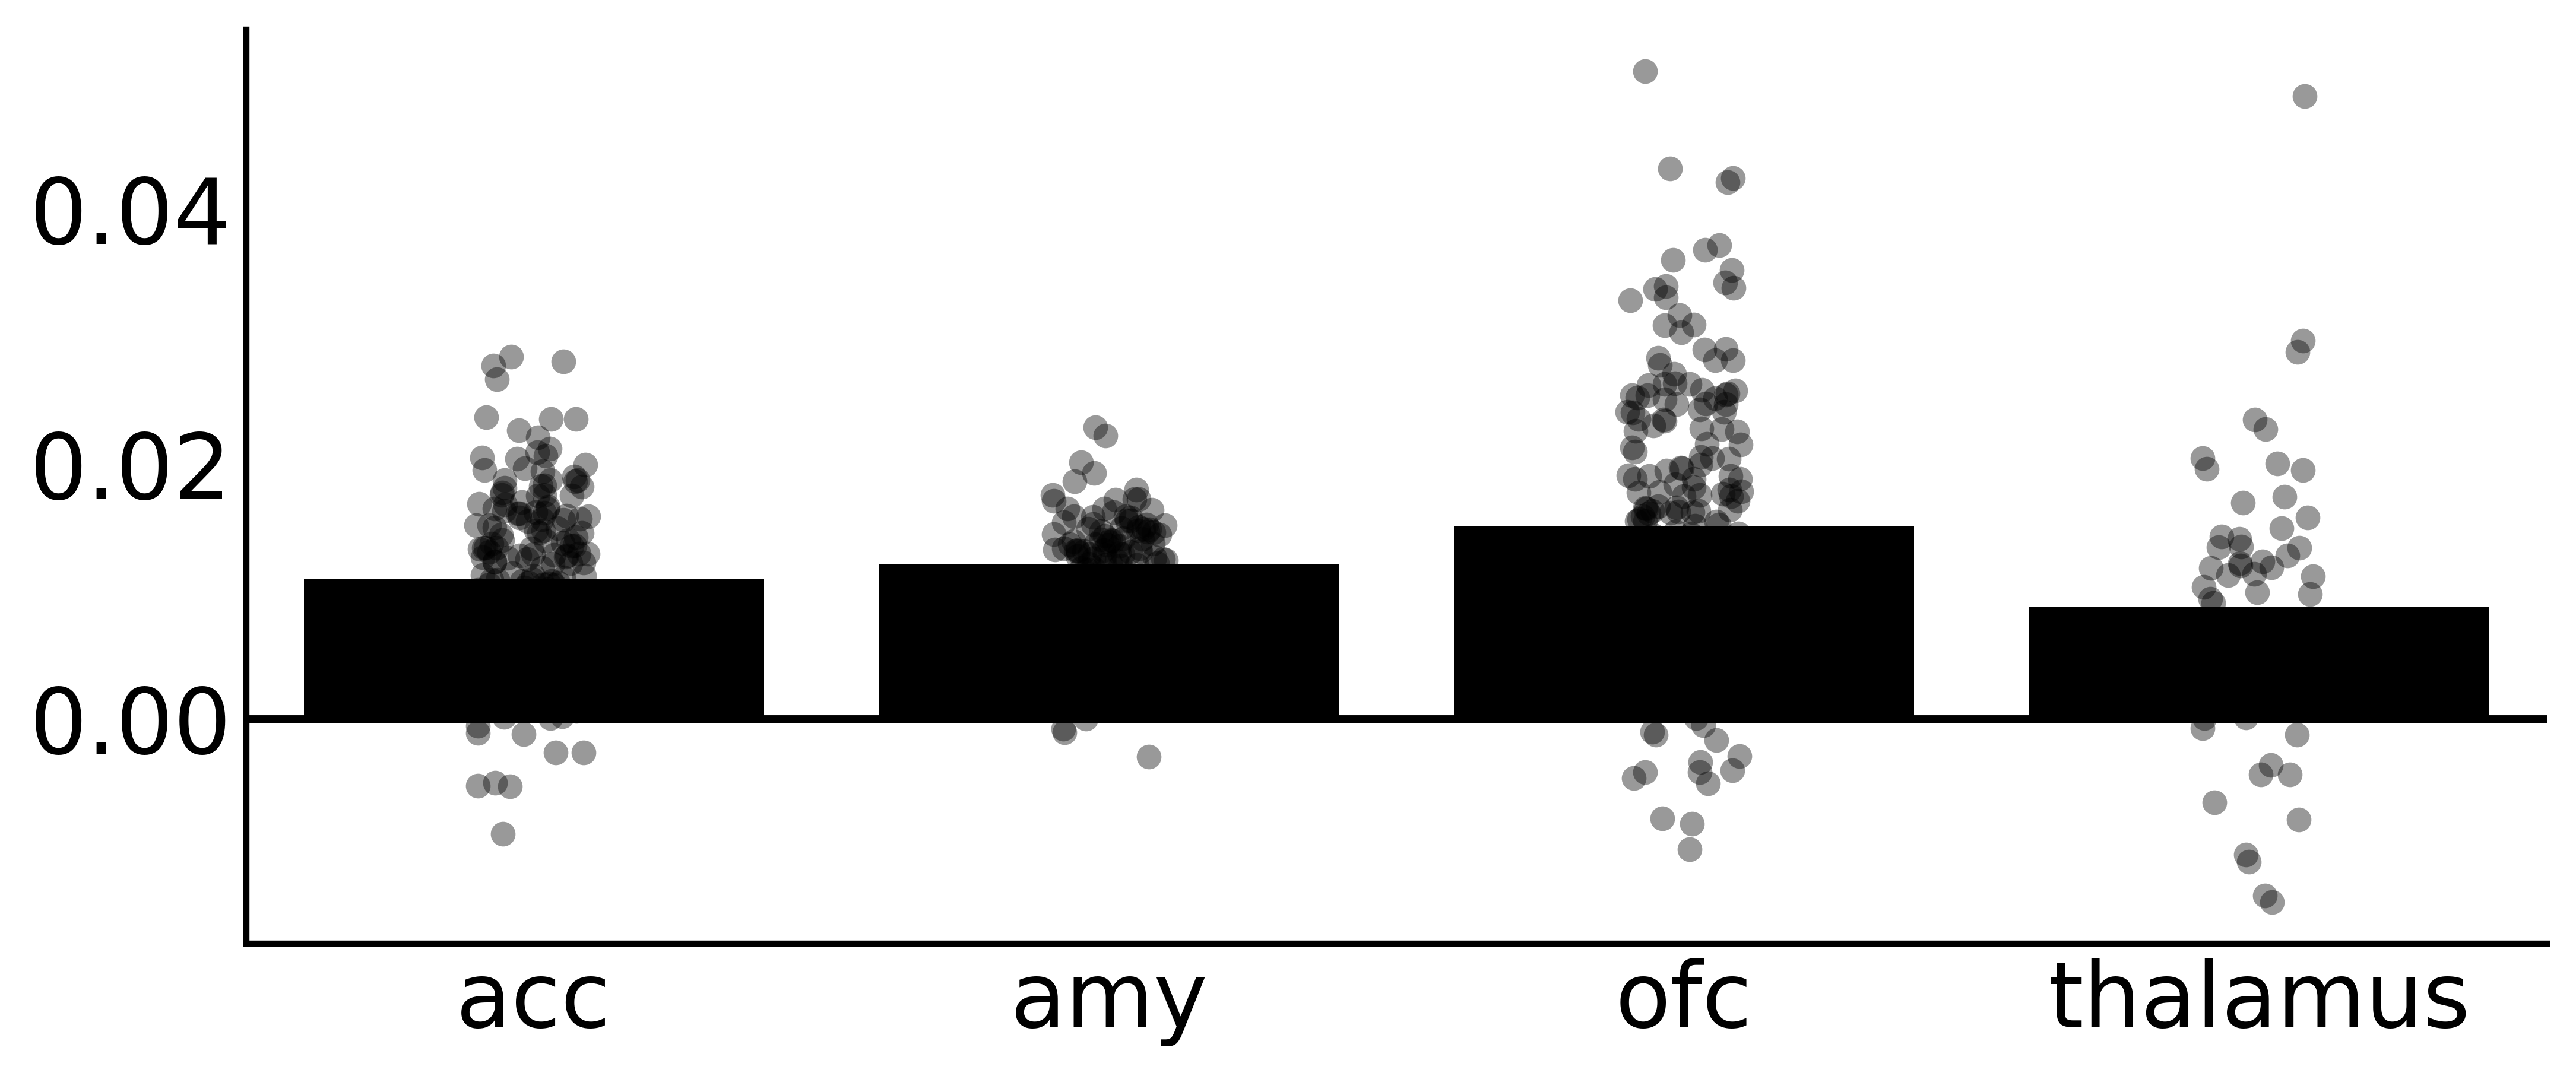

In [37]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


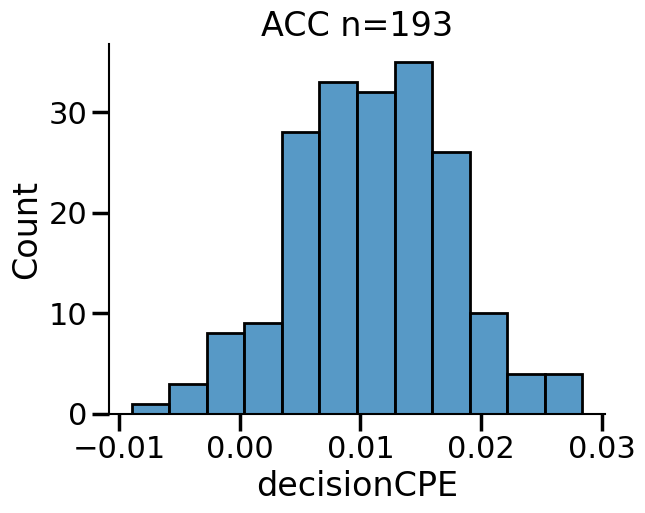

In [38]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

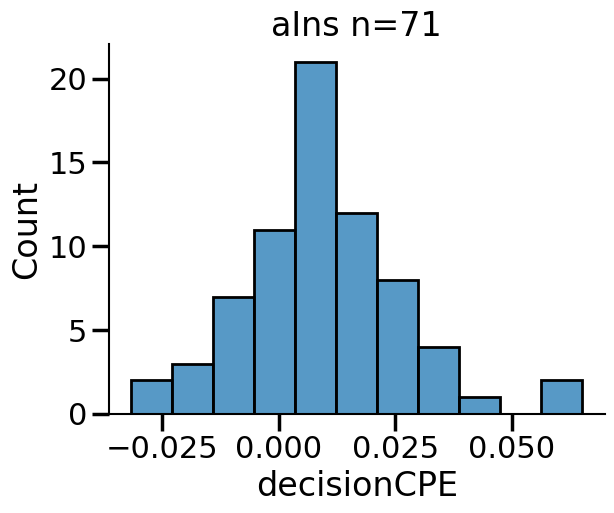

In [39]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
plt.title(f'aIns n={n}')

sns.despine()

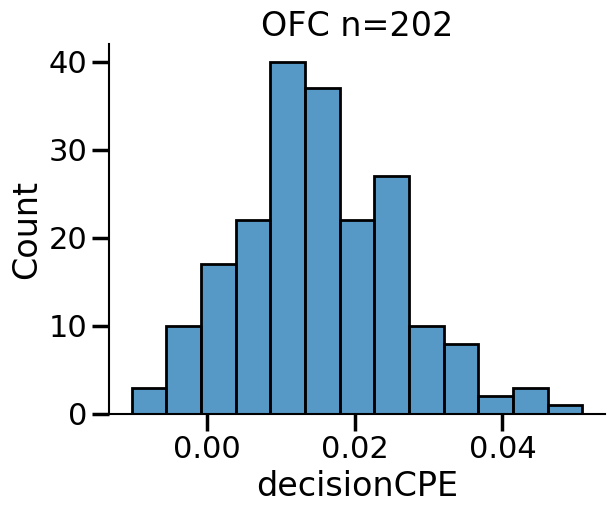

In [40]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

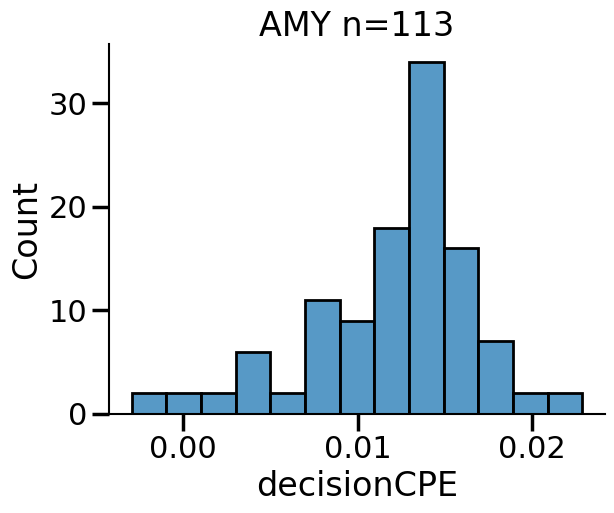

In [41]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
plt.title(f'AMY n={n}')

sns.despine()

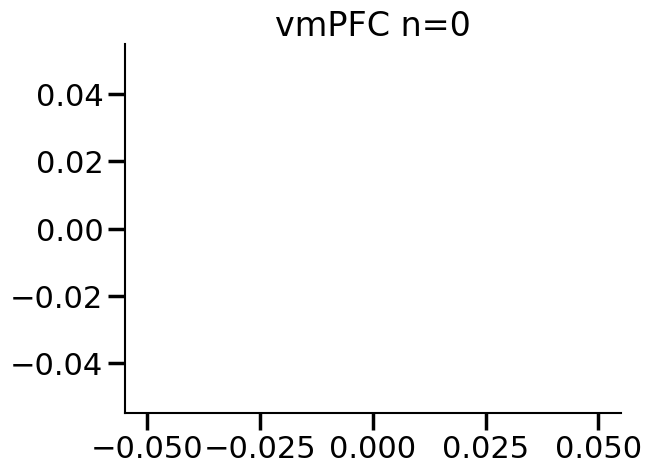

In [42]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'vmpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'vmpfc'].decisionCPE)
plt.title(f'vmPFC n={n}')

sns.despine()

In [43]:
sig_rois

['acc', 'amy', 'ofc', 'thalamus']

In [44]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.08840164293558497 0.22150653826368924
dmpfc pearsonr -0.19879667177065727 0.003345261501562464
amy pearsonr -0.14414522475350425 0.1277050680446401
sts pearsonr -0.008163780874057487 0.9196955659904172
ains pearsonr -0.33176455706532765 0.004707389159105623
vlpfc pearsonr -0.07770688252832202 0.48773649766054844
hpc pearsonr -0.2844818320277422 0.0008257533572014742
mtg pearsonr -0.10891124402971496 0.41998458844300846
ofc pearsonr 0.04844192902702493 0.49358462271667153
pins pearsonr 0.30803865884109427 0.01664738034267177
dlpfc pearsonr -0.0018679577772217773 0.9847650254080386
smg pearsonr 0.3026899869625802 0.013498829611583149
stg pearsonr -0.11163795941548135 0.25687703081562896
thalamus pearsonr -0.12339456018901106 0.3561003859376153


In [45]:
sig_rho

[('dmpfc', -0.19879667177065727, 0.003345261501562464),
 ('ains', -0.33176455706532765, 0.004707389159105623),
 ('hpc', -0.2844818320277422, 0.0008257533572014742),
 ('pins', 0.30803865884109427, 0.01664738034267177),
 ('smg', 0.3026899869625802, 0.013498829611583149)]

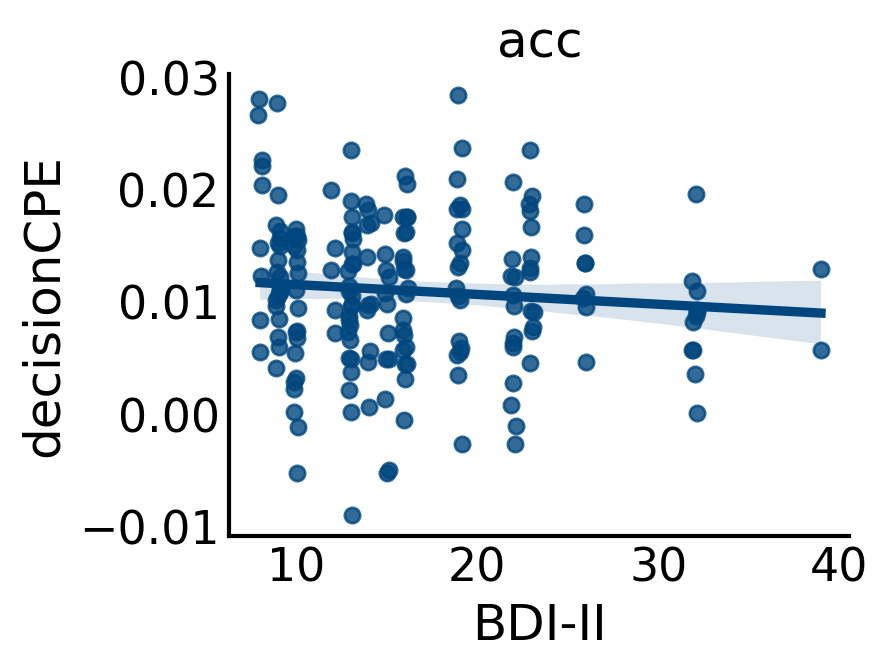

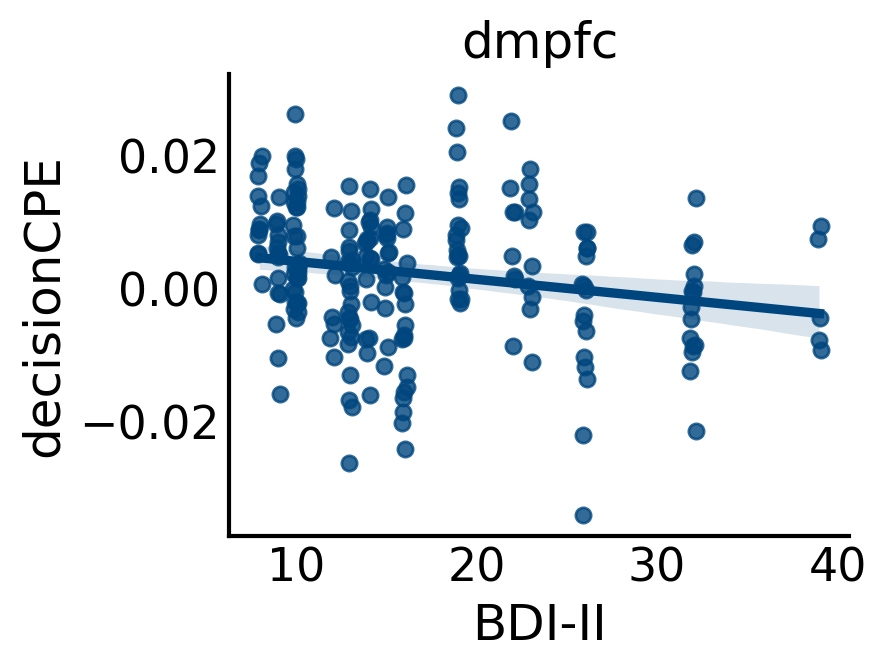

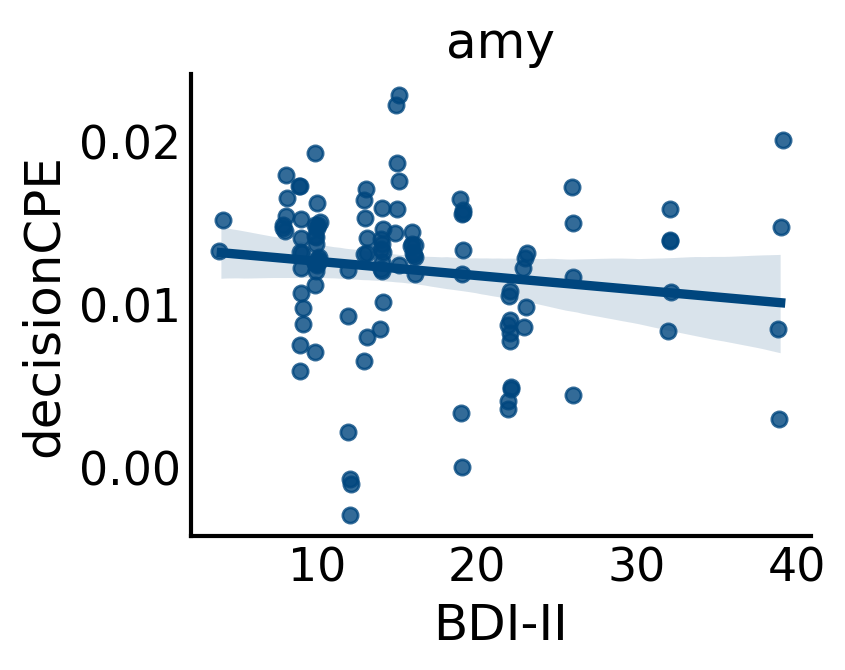

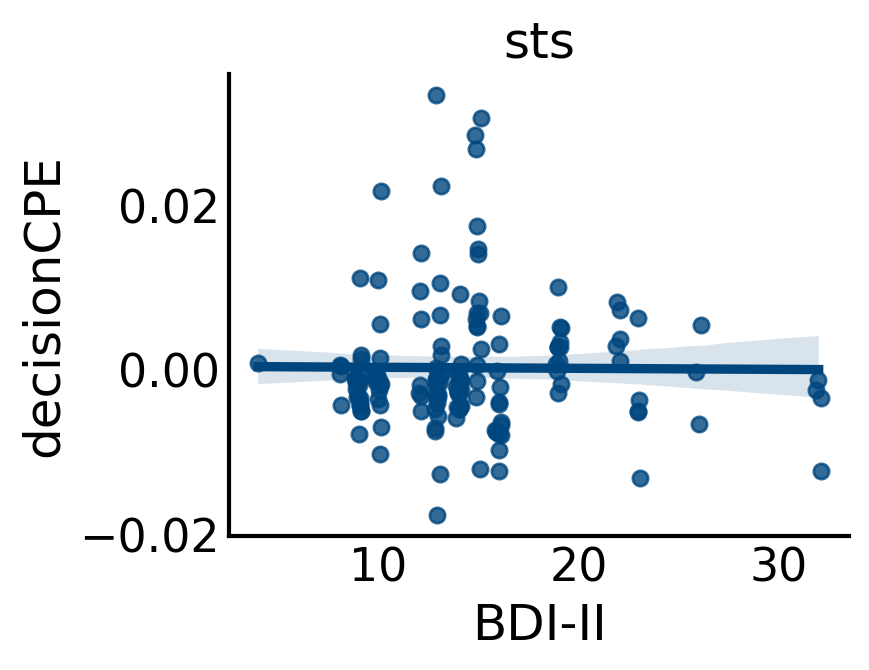

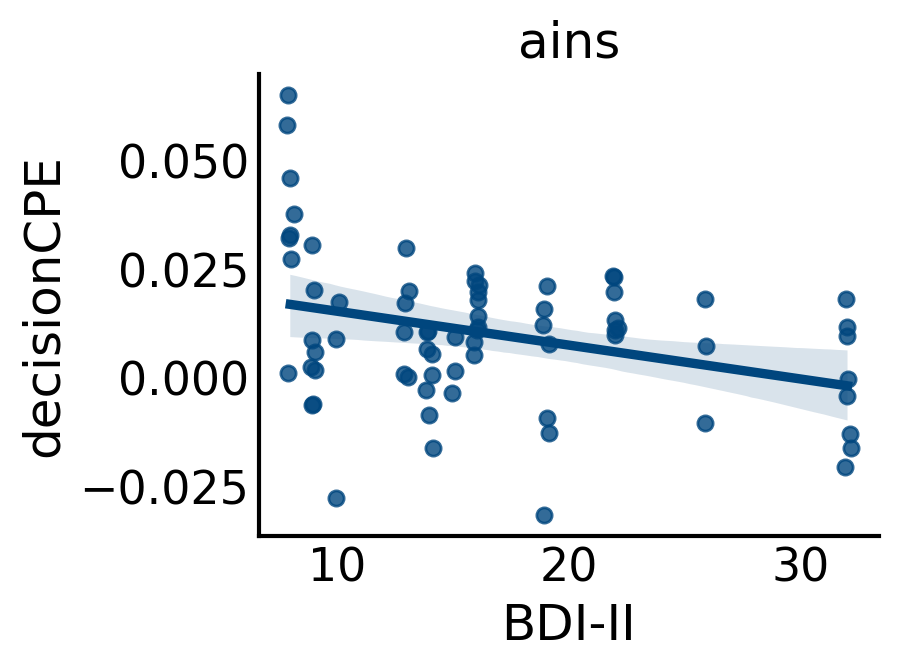

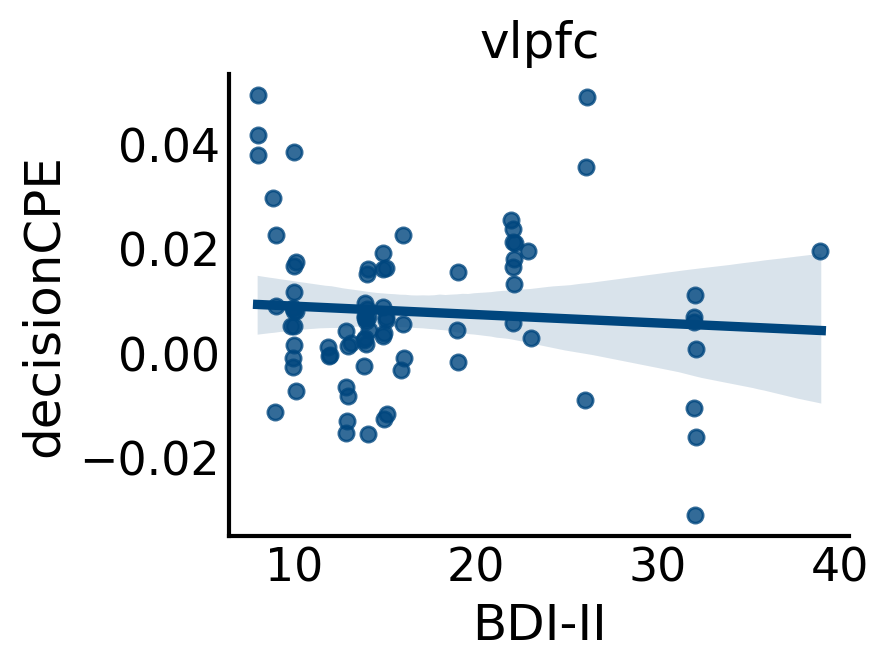

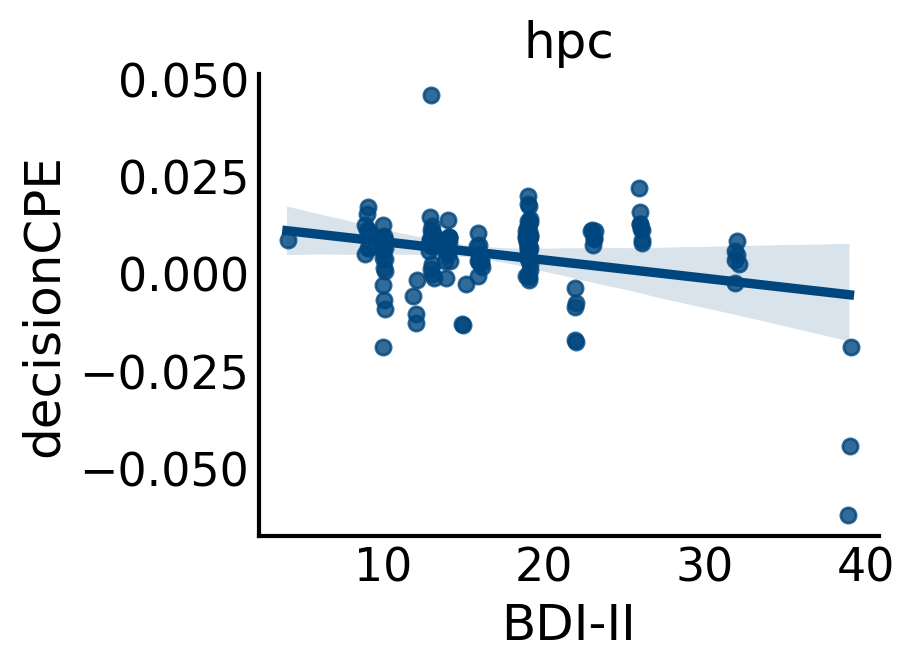

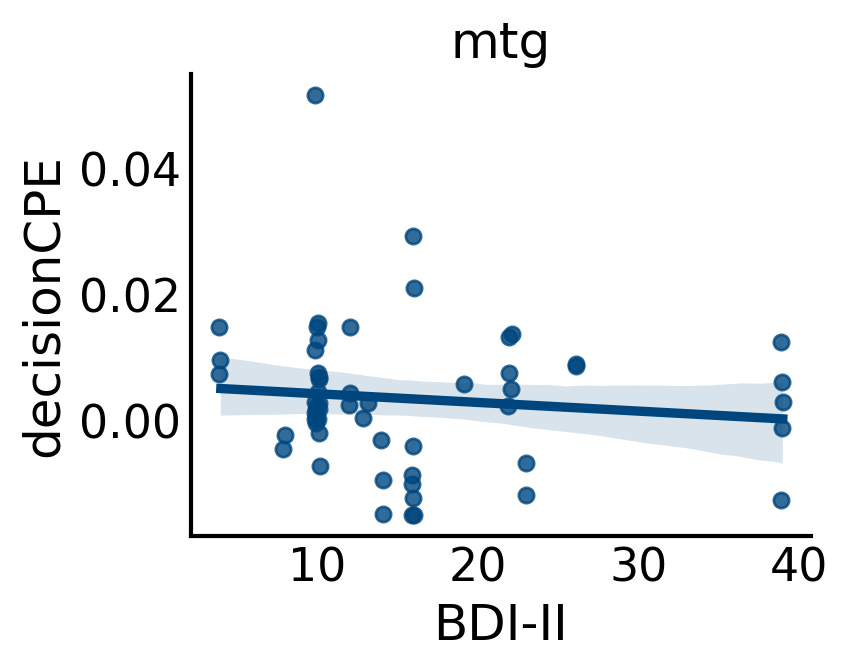

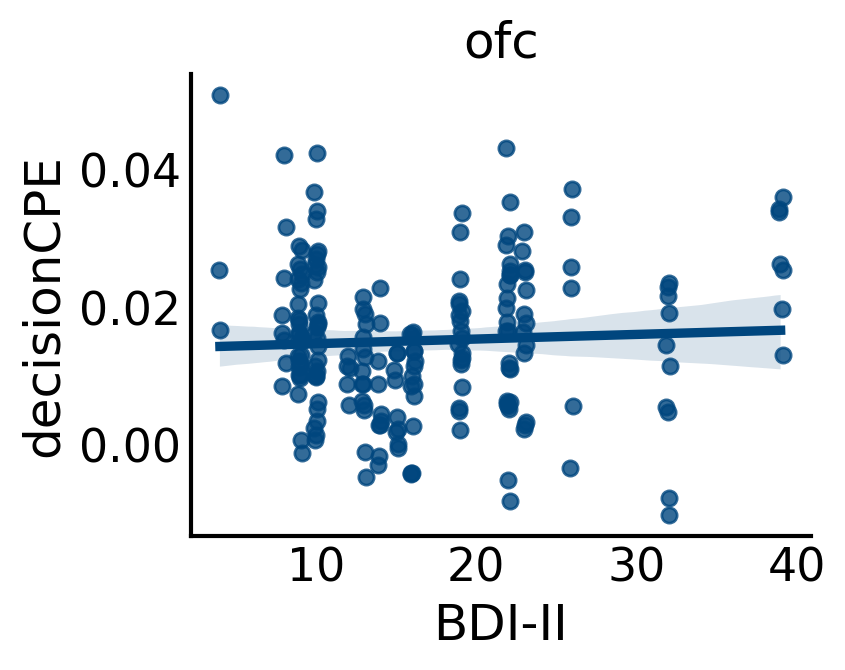

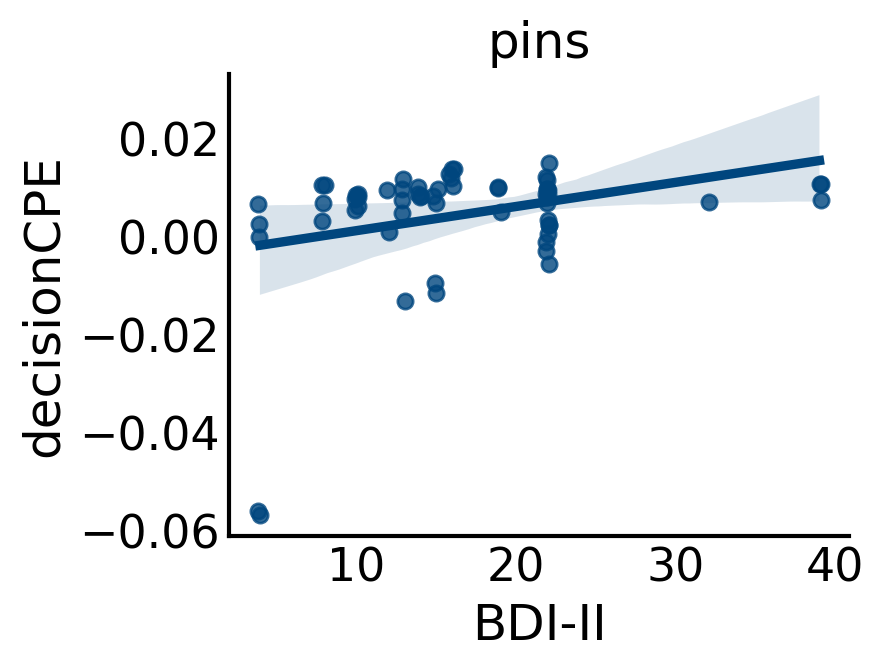

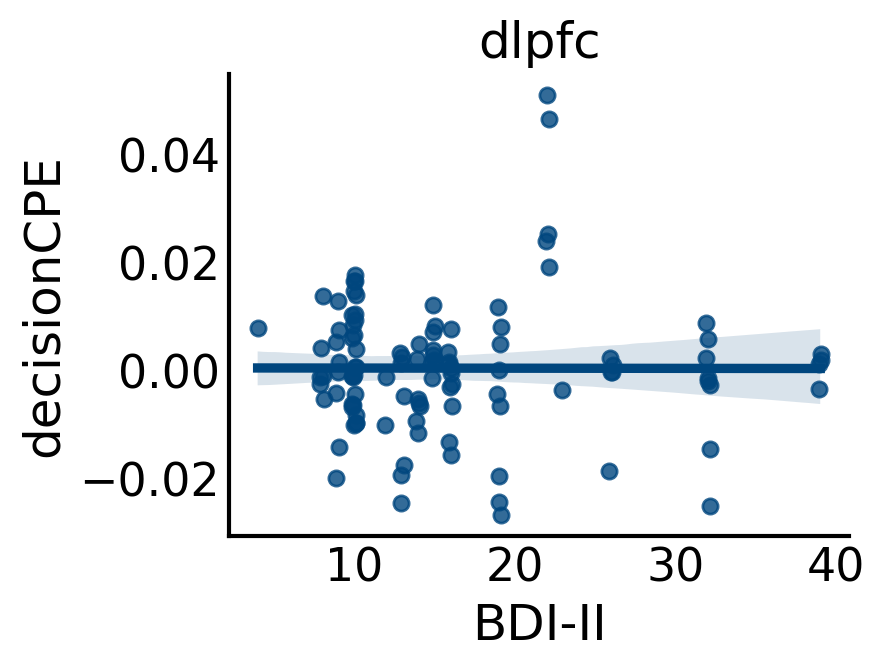

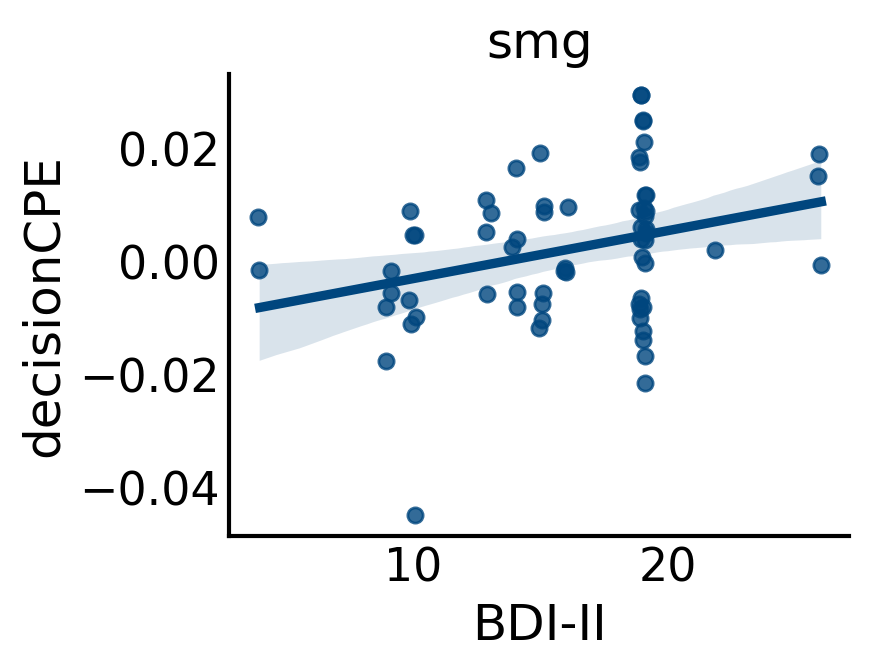

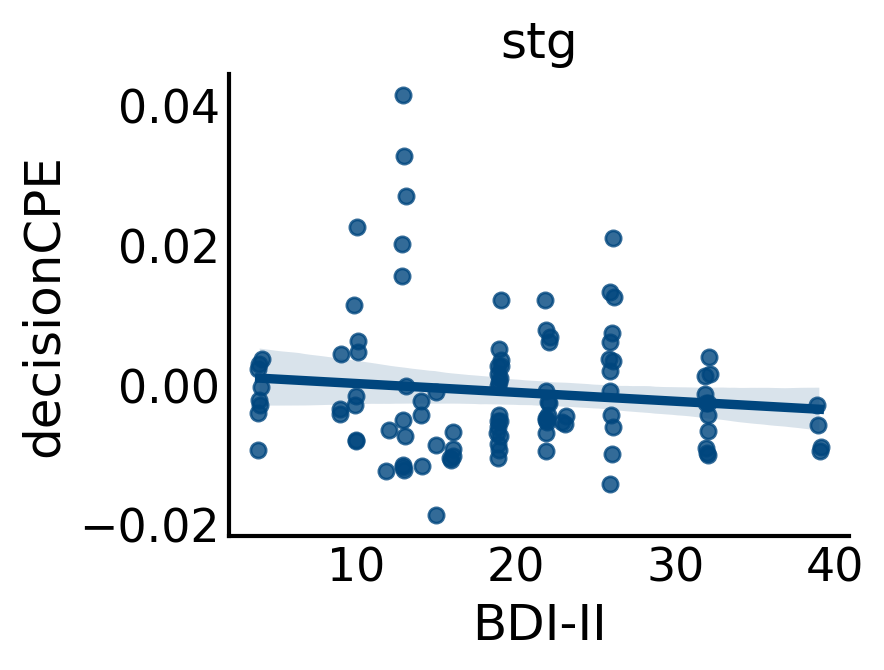

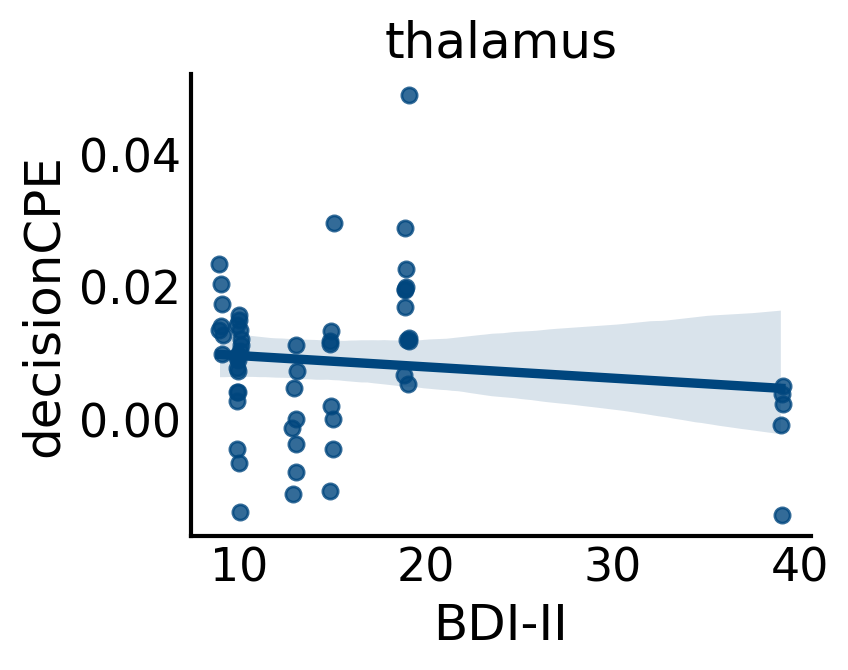

In [46]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [50]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [51]:
rt_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             logRT_t1    
No. Observations:             244112              Method:                         ML          
No. Groups:                   1776                Scale:                          0.1292      
Min. group size:              65                  Log-Likelihood:                 -102349.4779
Max. group size:              148                 Converged:                      No          
Mean group size:              137.5                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.027    0.006 165.909 0.00

205145.5494682047


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [52]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']


In [53]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [54]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}RT_{band}_roi_results.csv')

In [55]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TrialEV,raw_TotalProfit,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,GambleChoice,TrialEV,TotalProfit,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.124543,0.010553,0.015791,0.001553,0.010199,0.005155,-0.118760,0.886222,0.029256,0.034231,-0.020381,0.042798,0.032951,-0.188859,gamma
1,DA023_lac2-lac3,DA023,acc,14,-0.124409,0.010012,0.015378,0.001440,0.009279,0.042737,0.000561,0.886356,0.028715,0.033818,-0.020495,0.041877,0.070534,-0.069538,gamma
2,DA023_lac3-lac4,DA023,acc,14,-0.122943,0.008538,0.013015,0.001452,0.006806,-0.314054,0.047879,0.887822,0.027241,0.031455,-0.020483,0.039404,-0.286258,-0.022220,gamma
3,MS002_lacas1-lacas2,MS002,acc,14,-0.296596,0.009345,0.023250,0.057002,0.009191,0.209736,0.084872,0.714169,0.028048,0.041690,0.035067,0.041789,0.237532,0.014773,gamma
4,MS002_lacas2-lacas3,MS002,acc,14,-0.297015,0.010296,0.024139,0.050574,0.009792,0.126592,-0.007662,0.713750,0.028999,0.042579,0.028639,0.042391,0.154388,-0.077761,gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.252596,0.036160,0.028662,-0.132379,0.020195,0.002920,0.071019,1.241585,0.058184,0.022627,-0.133042,0.070376,-0.062407,0.168298,gamma
1772,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.247689,0.036878,0.028644,-0.133446,0.020342,-0.083880,-0.076116,1.236678,0.058903,0.022609,-0.134109,0.070523,-0.149207,0.021162,gamma
1773,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.254215,0.036247,0.028822,-0.132369,0.020144,0.020497,-0.122944,1.243204,0.058271,0.022787,-0.133032,0.070325,-0.044830,-0.025665,gamma
1774,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.255856,0.035048,0.028426,-0.132860,0.020283,0.145573,-0.167248,1.244845,0.057073,0.022391,-0.133523,0.070464,0.080246,-0.069970,gamma


In [56]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-8.355520064229813, pvalue=1.2890860603449088e-14, df=192),
 'dmpfc': TtestResult(statistic=-1.024833343873764, pvalue=0.3065935026242324, df=215),
 'amy': TtestResult(statistic=-8.01526266547707, pvalue=1.1556823844337775e-12, df=112),
 'sts': TtestResult(statistic=3.499160237777621, pvalue=0.0006104687795620954, df=154),
 'ains': TtestResult(statistic=3.0938686426724304, pvalue=0.0028383955295733054, df=70),
 'vlpfc': TtestResult(statistic=-1.7351836666459182, pvalue=0.08651155123219617, df=81),
 'hpc': TtestResult(statistic=2.0784418891784715, pvalue=0.03957633776458411, df=134),
 'mtg': TtestResult(statistic=6.252788089308446, pvalue=5.879145096413292e-08, df=56),
 'ofc': TtestResult(statistic=2.890639505166311, pvalue=0.004267083250845715, df=201),
 'pins': TtestResult(statistic=0.2490091192073166, pvalue=0.8042185414174614, df=59),
 'dlpfc': TtestResult(statistic=-1.6763383511603775, pvalue=0.09661900019821129, df=106),
 'motor': TtestResult(statisti

In [57]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TrialEV,raw_TotalProfit,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,GambleChoice,TrialEV,TotalProfit,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.124543,0.010553,0.015791,0.001553,0.010199,0.005155,-0.118760,0.886222,0.029256,0.034231,-0.020381,0.042798,0.032951,-0.188859,gamma
1,DA023_lac2-lac3,DA023,acc,14,-0.124409,0.010012,0.015378,0.001440,0.009279,0.042737,0.000561,0.886356,0.028715,0.033818,-0.020495,0.041877,0.070534,-0.069538,gamma
2,DA023_lac3-lac4,DA023,acc,14,-0.122943,0.008538,0.013015,0.001452,0.006806,-0.314054,0.047879,0.887822,0.027241,0.031455,-0.020483,0.039404,-0.286258,-0.022220,gamma
3,MS002_lacas1-lacas2,MS002,acc,14,-0.296596,0.009345,0.023250,0.057002,0.009191,0.209736,0.084872,0.714169,0.028048,0.041690,0.035067,0.041789,0.237532,0.014773,gamma
4,MS002_lacas2-lacas3,MS002,acc,14,-0.297015,0.010296,0.024139,0.050574,0.009792,0.126592,-0.007662,0.713750,0.028999,0.042579,0.028639,0.042391,0.154388,-0.077761,gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.252596,0.036160,0.028662,-0.132379,0.020195,0.002920,0.071019,1.241585,0.058184,0.022627,-0.133042,0.070376,-0.062407,0.168298,gamma
1772,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.247689,0.036878,0.028644,-0.133446,0.020342,-0.083880,-0.076116,1.236678,0.058903,0.022609,-0.134109,0.070523,-0.149207,0.021162,gamma
1773,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.254215,0.036247,0.028822,-0.132369,0.020144,0.020497,-0.122944,1.243204,0.058271,0.022787,-0.133032,0.070325,-0.044830,-0.025665,gamma
1774,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.255856,0.035048,0.028426,-0.132860,0.020283,0.145573,-0.167248,1.244845,0.057073,0.022391,-0.133523,0.070464,0.080246,-0.069970,gamma


In [58]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [59]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [60]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [61]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [62]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TrialEV,TotalProfit,decisionCPE,band_pow,decisionCPE:band_pow,roi,roi_cpepow_pval
0,1.010765,0.018703,0.018440,-0.021935,0.032598,0.027796,-0.070099,acc,0.103539
1,0.982826,0.025013,0.023610,-0.001859,0.043733,0.057928,-0.013892,dmpfc,0.734479
2,1.030385,0.021023,0.027077,-0.012028,0.036000,-0.049841,-0.084493,amy,0.202327
3,1.030211,0.034286,0.034027,-0.031784,0.025699,0.023917,0.029673,sts,0.424917
4,0.981147,0.038896,0.029723,-0.004850,0.046495,0.021937,0.067892,ains,0.327202
5,1.006646,0.027603,0.040730,0.020729,0.032877,0.035199,-0.021818,vlpfc,NaN
6,0.990819,0.009640,0.011379,0.008570,0.033076,-0.017104,0.037590,hpc,0.562594
7,1.086182,0.001407,0.012574,0.000169,0.049866,0.006100,0.086191,mtg,0.174374
8,1.032572,0.015688,0.019294,-0.004206,0.037287,0.035939,0.022140,ofc,0.493499
9,1.102565,-0.002678,0.025322,-0.001428,0.028852,-0.002064,0.002197,pins,0.950344


In [63]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0025

In [64]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

[]

In [65]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [ ]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [66]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.11944202338335581 0.09802786419701547
dmpfc pearsonr -0.37295566712229933 1.5597780066658917e-08
amy pearsonr 0.01633880750175382 0.8636228876320455
sts pearsonr -0.07735669749570492 0.33870765576408157
ains pearsonr -0.1070008581727988 0.3744572305300142
vlpfc pearsonr -0.5151813572915859 7.331984495490661e-07
hpc pearsonr -0.20128997548907124 0.01922985778885069
mtg pearsonr -0.09784896010076376 0.46899374913447484
ofc pearsonr -0.28304985008037375 4.470467791278583e-05
pins pearsonr -0.40619289945994597 0.0012809026208296607
dlpfc pearsonr -0.2464515591656795 0.010498233574066401
motor pearsonr -0.27478106635567084 0.18374075003859391
vmpfc pearsonr -0.1205544732016986 0.5837454198868827
phg pearsonr 0.2339540749050521 0.2603383511705286
smg pearsonr 0.02292074755397674 0.8550529064414225
stg pearsonr -0.07106406787483727 0.47128815580729744
mcc pearsonr -0.5856717511487078 0.0010588934676078235
temporal pole pearsonr 0.17200661162562578 0.3548314460792209
parietal p

In [67]:
sig_rho

[('dmpfc', -0.37295566712229933, 1.5597780066658917e-08),
 ('vlpfc', -0.5151813572915859, 7.331984495490661e-07),
 ('hpc', -0.20128997548907124, 0.01922985778885069),
 ('ofc', -0.28304985008037375, 4.470467791278583e-05),
 ('pins', -0.40619289945994597, 0.0012809026208296607),
 ('dlpfc', -0.2464515591656795, 0.010498233574066401),
 ('mcc', -0.5856717511487078, 0.0010588934676078235)]

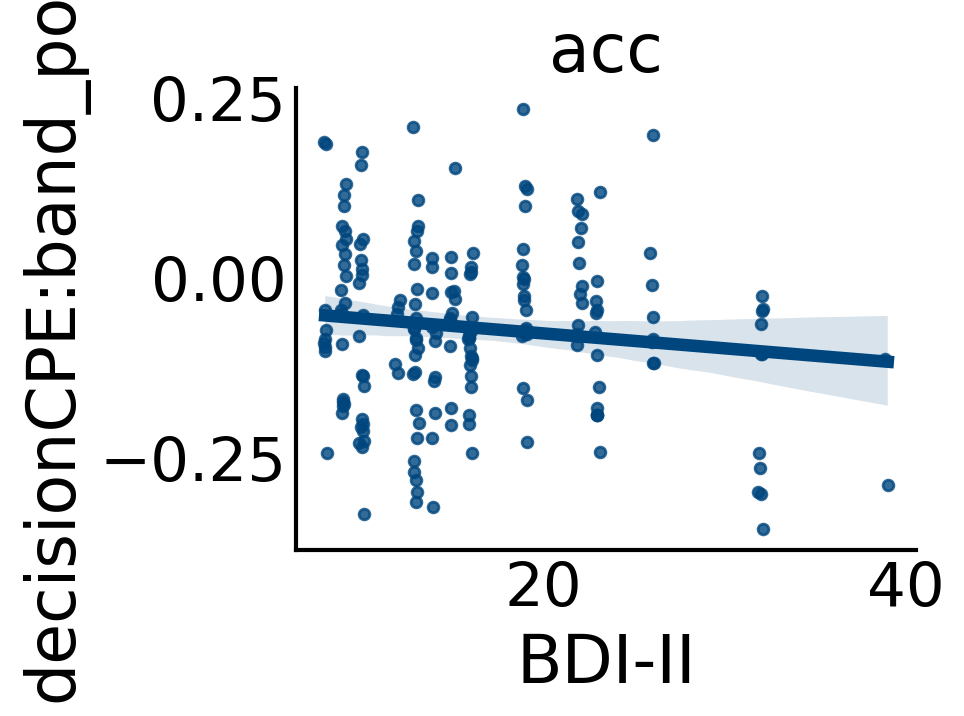

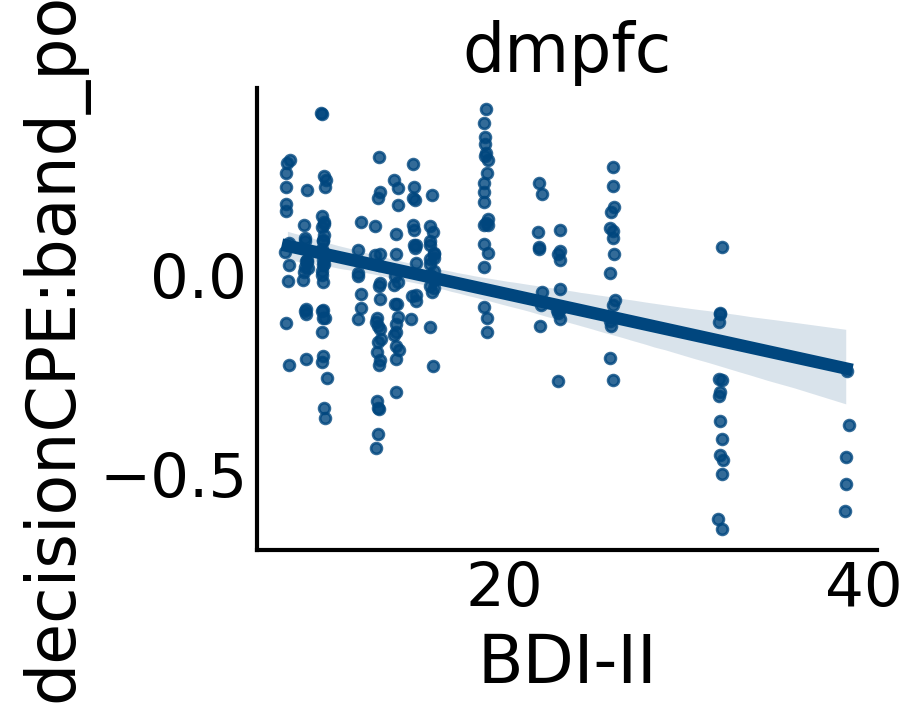

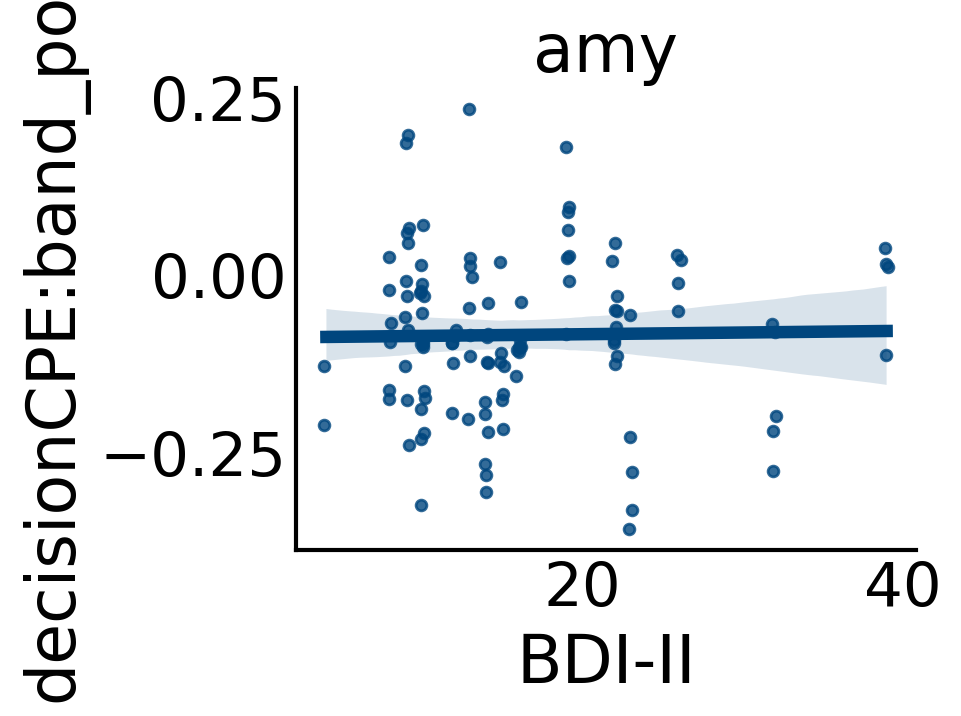

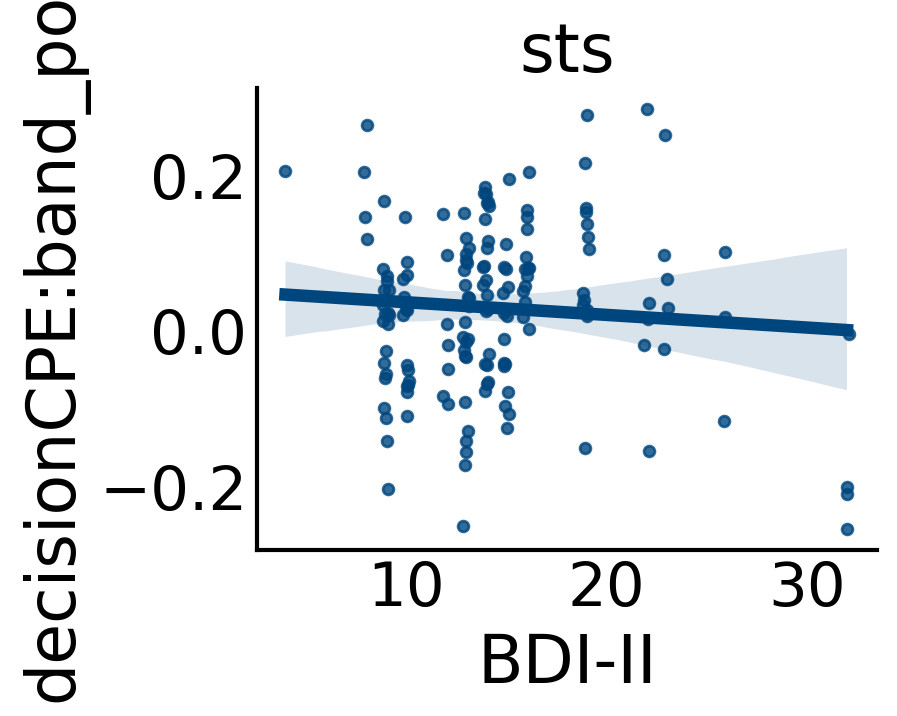

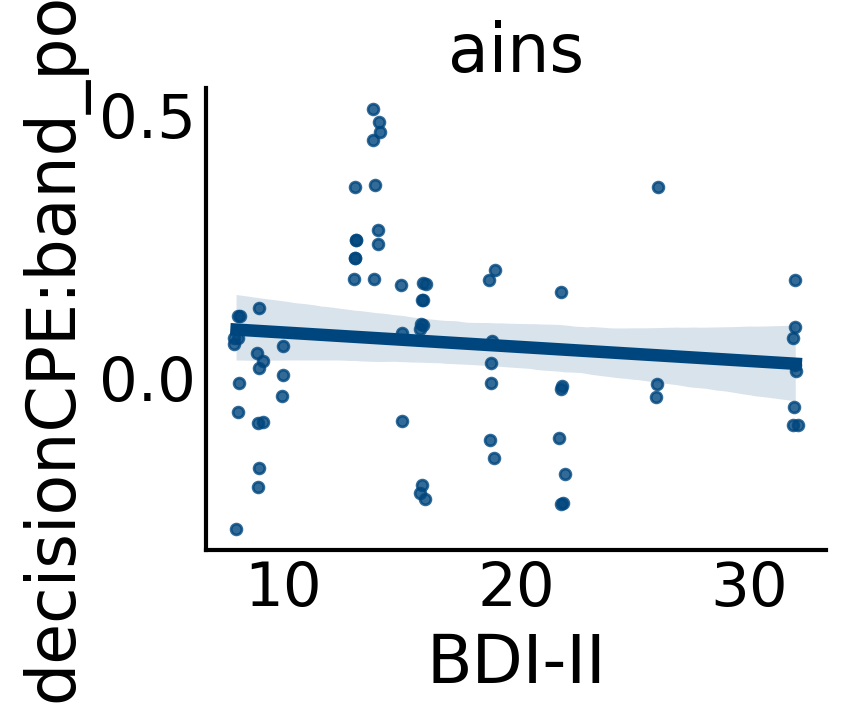

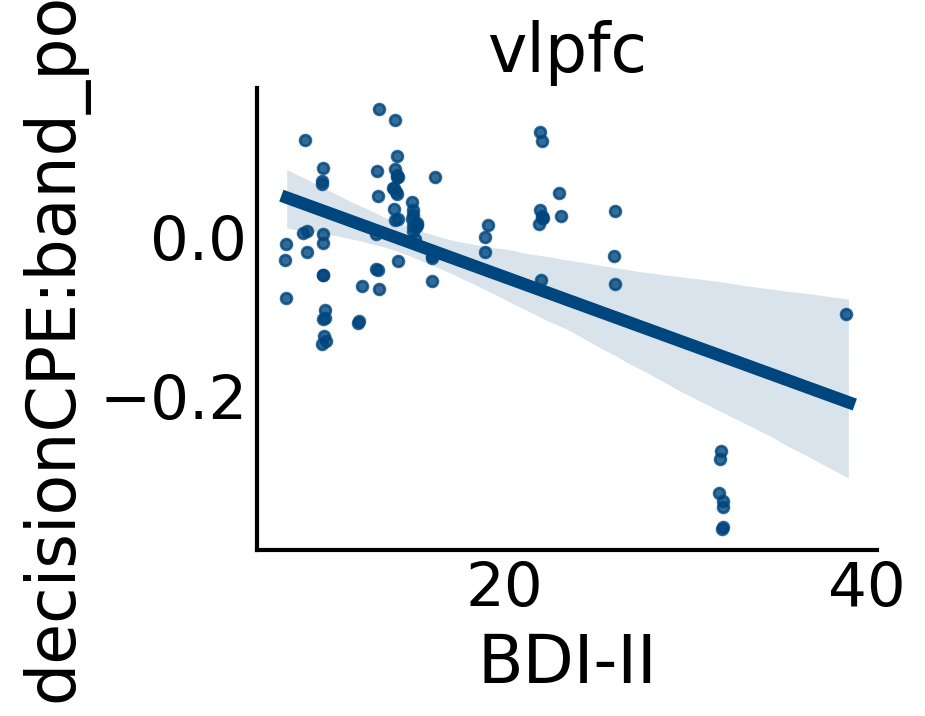

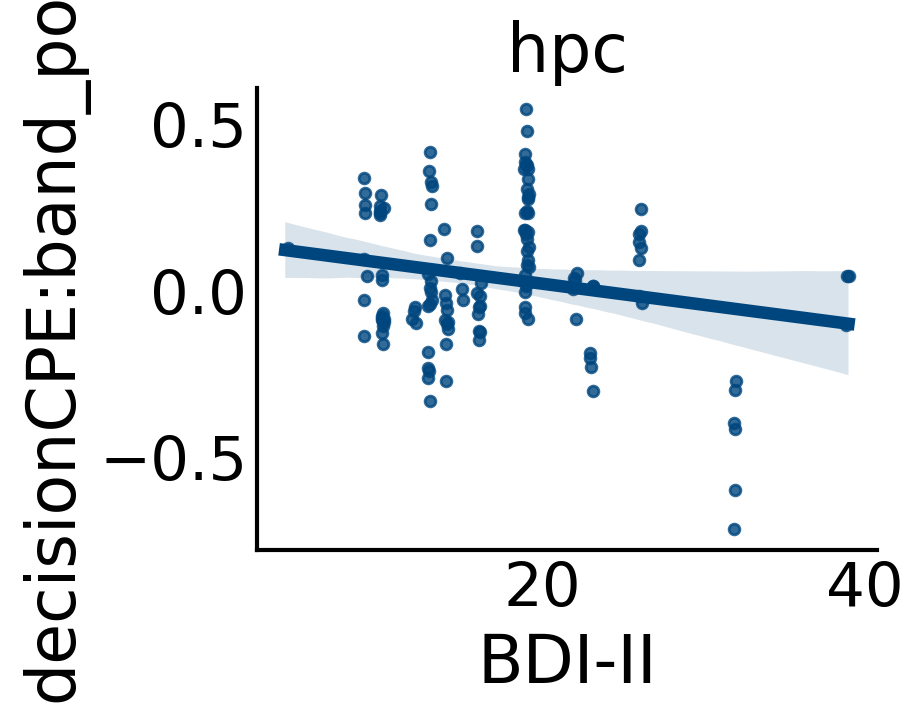

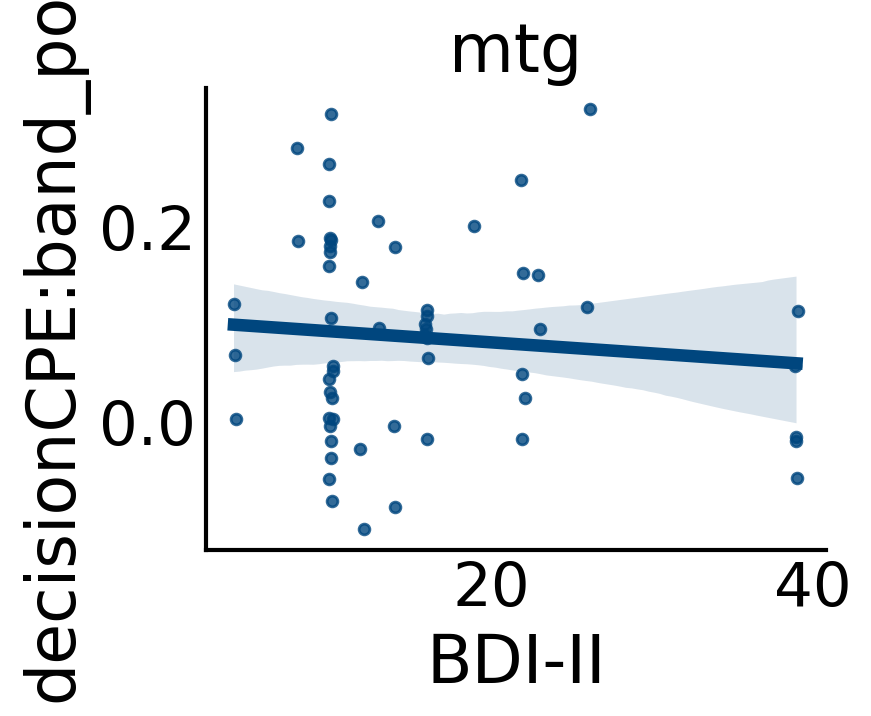

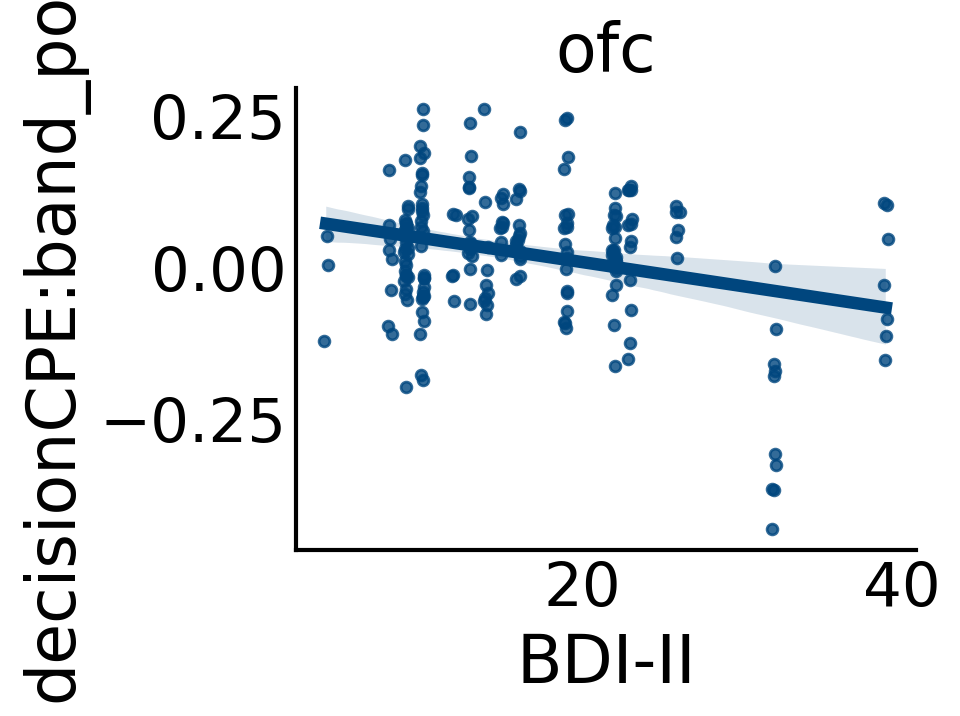

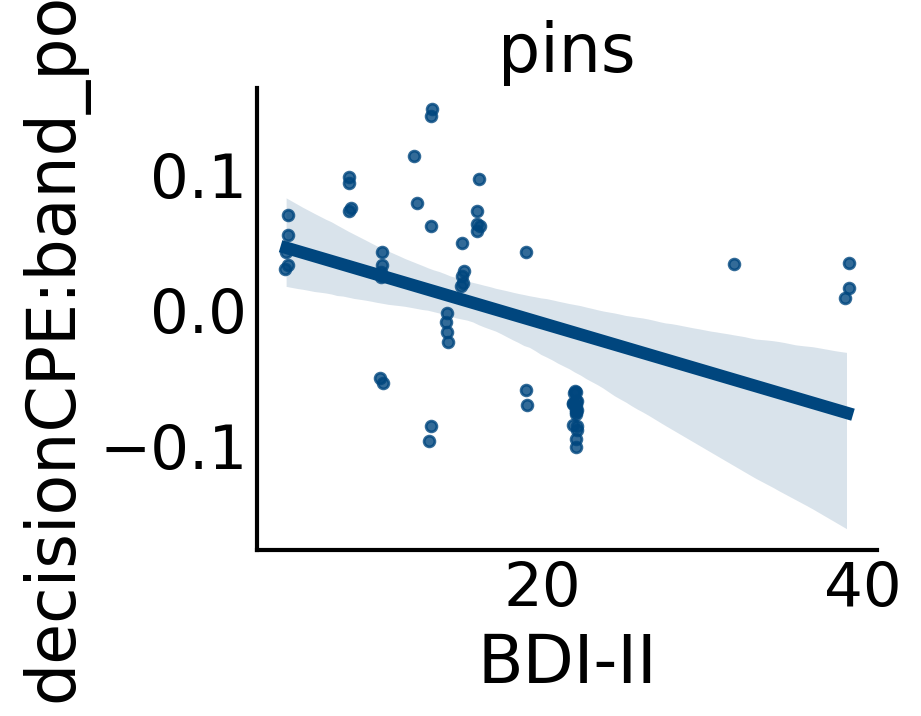

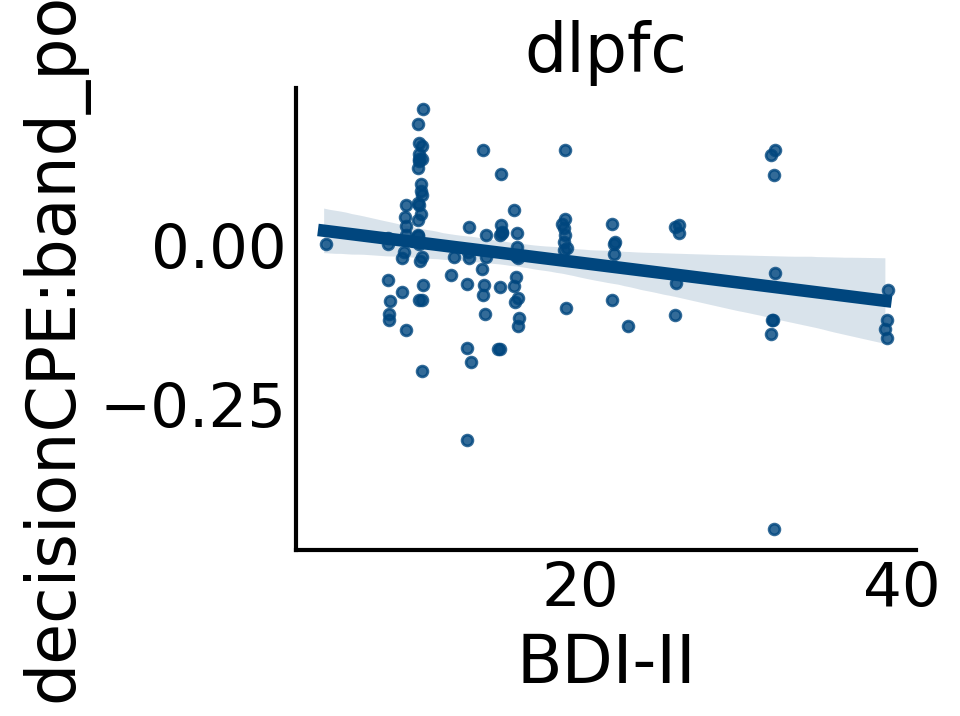

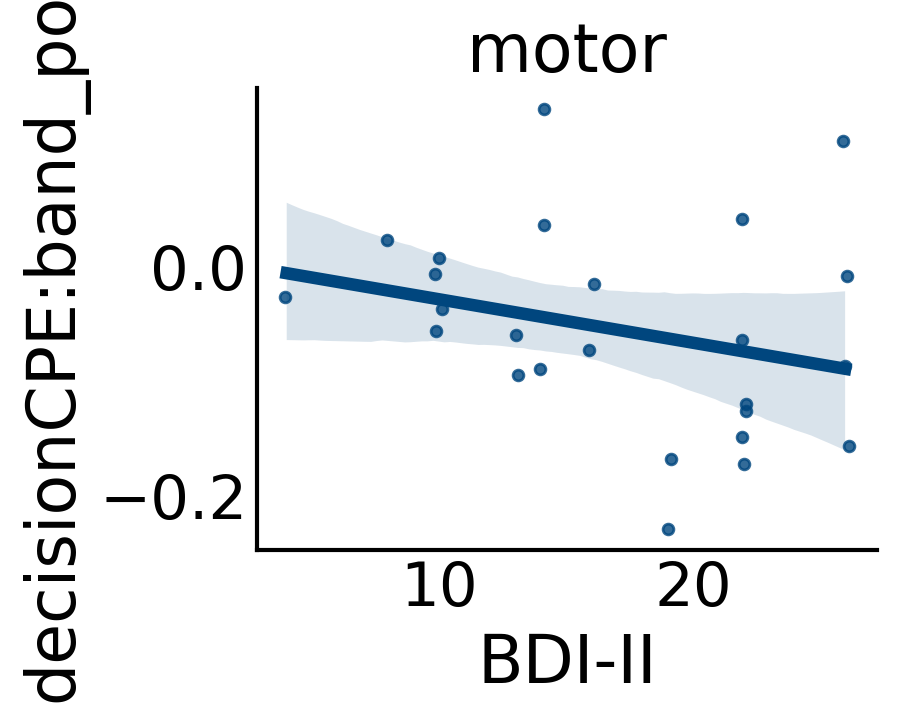

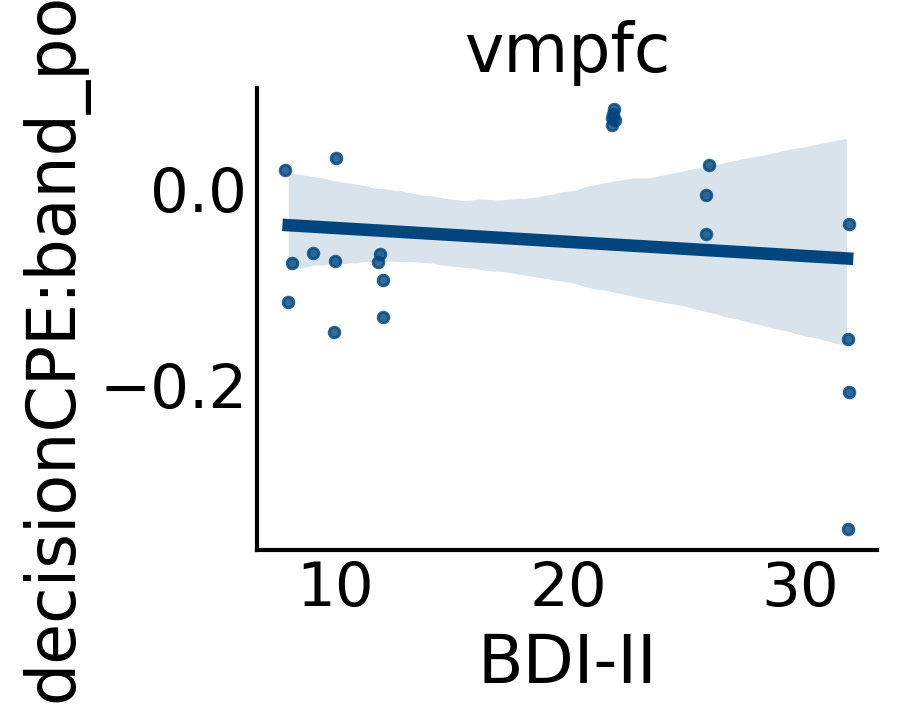

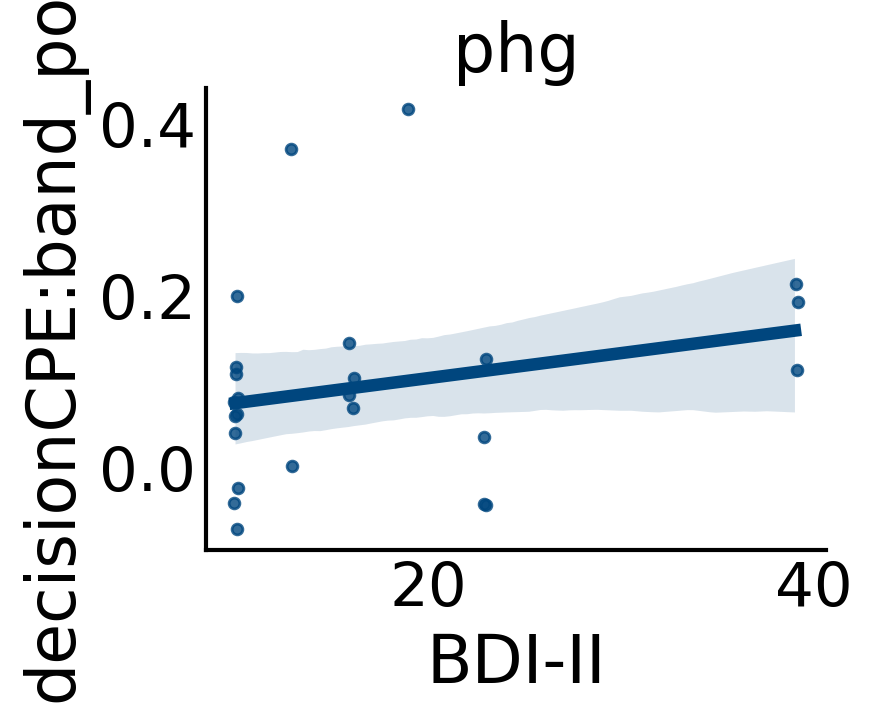

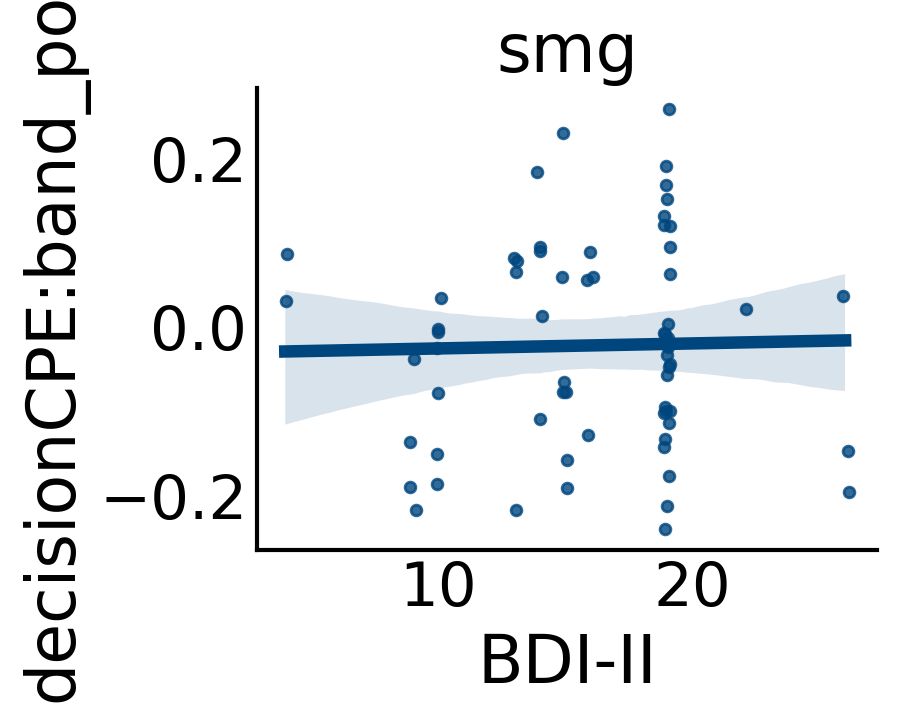

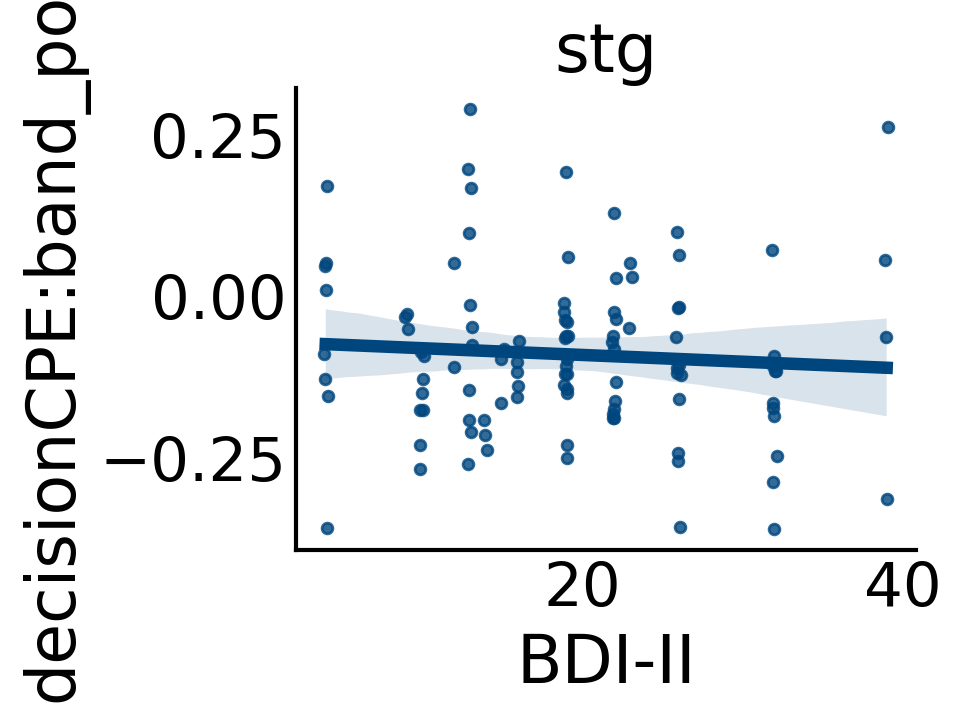

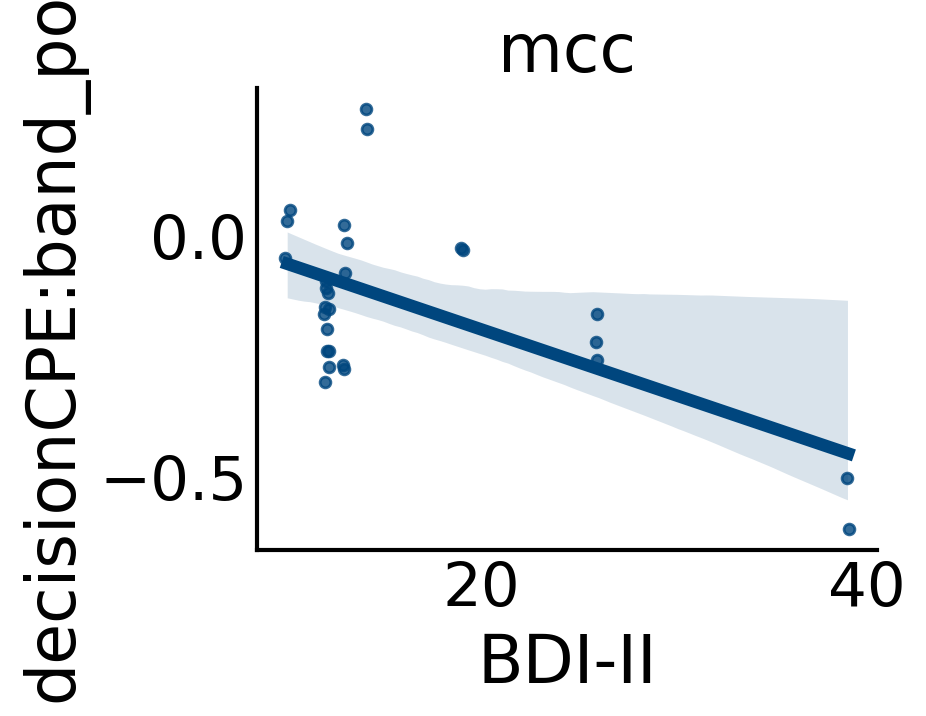

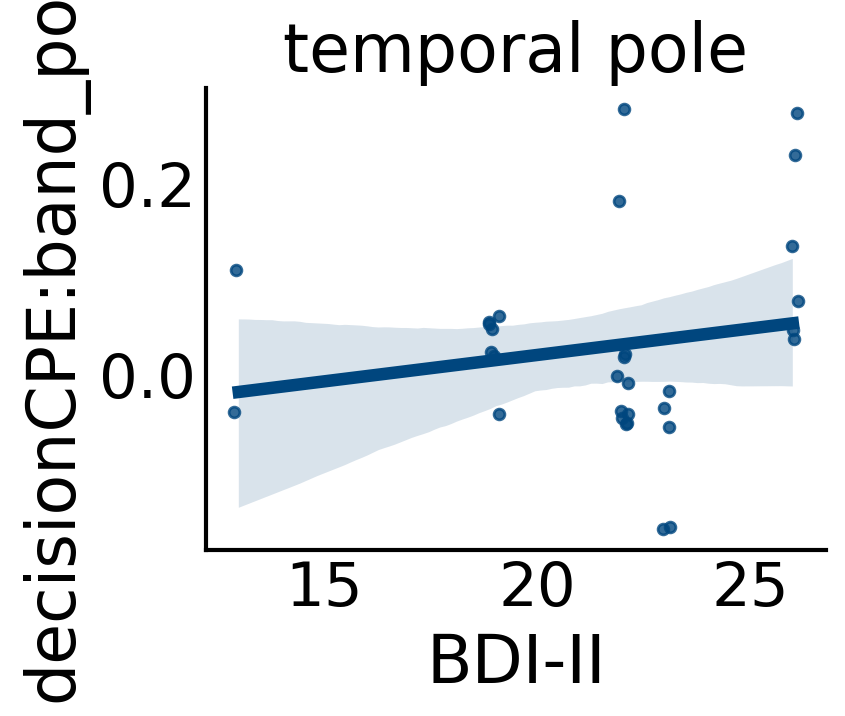

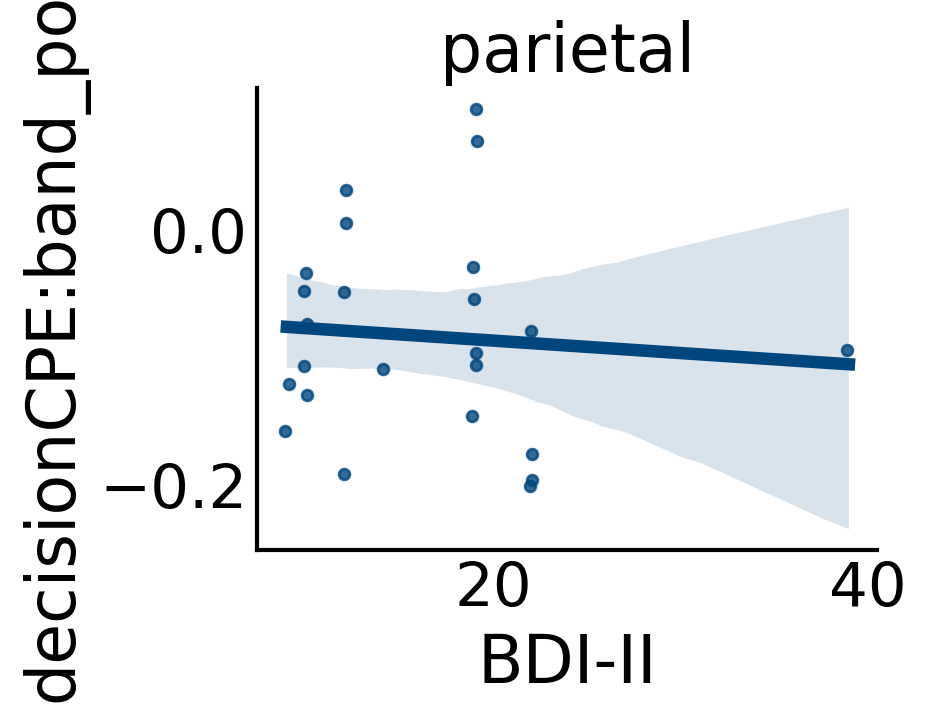

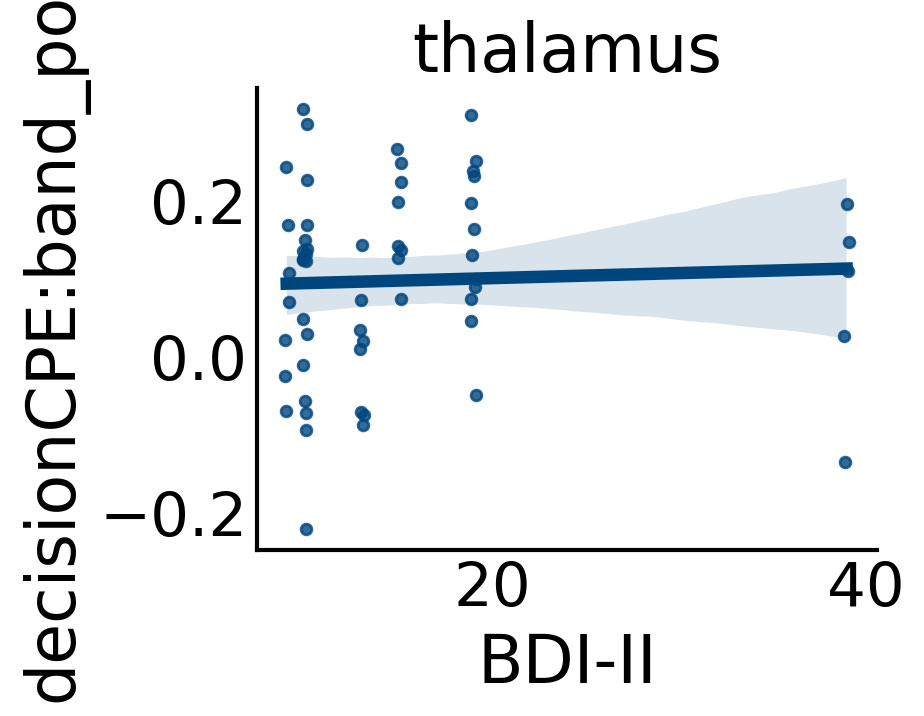

In [68]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    